In [114]:
from torchvision import datasets, transforms

transforms = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms)


In [ ]:
#Dense layer

import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

np.random.seed(2)

def Relu(input):
    return input * (input > 0)

def derivative_relu(input): 
    return 1.0 * (input > 0)



#softmax function

def soft_max(input):
   # return np.exp(input)/np.sum(np.exp(input))

    exp_values = np.exp(input - np.max(input, axis=0, keepdims=True))
    return exp_values / np.sum(exp_values, axis=0, keepdims=True)


def cross_entropy_loss(y_pred,y_true):

    # Clip values to prevent log(0)

    for i in range(0, y_pred.shape[1]):
        for j in range(0, y_pred.shape[0]):
            if y_pred[j, i] < 1e-12:
                y_pred[j, i] = 1e-12
            elif y_pred[j, i] > 1 - 1e-12:
                y_pred[j, i] = 1 - 1e-12

    #y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    loss = -np.sum(y_true * np.log(y_pred))
    return loss


adam_iter = 1

class Adam_Optimizer:
    def __init__(self, beta_1, beta_2, ephsilon):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.ephsilon = ephsilon
        self.V_dw = 0
        self.S_dw = 0
        self.V_db = 0
        self.S_db = 0
        self.t = 0
        

    def get_params(self,DW,DB):

        self.t = self.t + 1


        self.V_dw = self.beta_1 * self.V_dw + (1 - self.beta_1) * DW
        self.V_db = self.beta_1 * self.V_db + (1 - self.beta_1) * DB

        self.S_dw = self.beta_2 * self.S_dw + (1 - self.beta_2) * np.power(DW , 2)
        self.S_db = self.beta_2 * self.S_db + (1 - self.beta_2) * np.power(DB , 2)

        V_dw_corrected = self.V_dw / (1 - self.beta_1 ** self.t)
        V_db_corrected = self.V_db / (1 - self.beta_1 ** self.t)


        S_dw_corrected = self.S_dw / (1 - self.beta_2 ** self.t)
        S_db_corrected = self.S_db / (1 - self.beta_2 ** self.t)

        return V_dw_corrected / (np.sqrt(S_dw_corrected) + self.ephsilon) , V_db_corrected / (np.sqrt(S_db_corrected) + self.ephsilon)


alpha  = 0

class Dense:

    def __init__(self,input_dim,output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Xavier initialization
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weight_matrix = np.random.uniform(-limit, limit, (output_dim, input_dim))
        self.bias = np.zeros((output_dim, 1))

        
        self.optimizer = Adam_Optimizer(0.9,0.999,1e-8)
        
    def forward(self,input_features):

        self.input_of_prev_layer = input_features

        forward_pass_val = np.dot(self.weight_matrix,self.input_of_prev_layer) + self.bias


        return forward_pass_val
    
    def backward(self,input):
        self.dZ = input
        self.dW = 1.0/input.shape[1] * np.dot(self.dZ,self.input_of_prev_layer.T)
        self.dB = 1.0/input.shape[1] * np.sum(self.dZ,axis=1,keepdims=True)


        #print(input.shape[1])
        
        unupdated_weight_matrix = self.weight_matrix


        updated_dW,updated_dB = self.optimizer.get_params(self.dW,self.dB)


        #print(adam_opt_arr)
        self.weight_matrix = self.weight_matrix - alpha * updated_dW #self.dW
        self.bias = self.bias - alpha * updated_dB #self.dB

        return np.dot(unupdated_weight_matrix.T,self.dZ)

class ActivationLayer:
    def __init__(self,func_name):
        self.func_name = func_name
    
    def forward(self,input_features):
        if self.func_name == 'Relu':
            self.Z_l = input_features
            return Relu(self.Z_l)
        if self.func_name == 'Softmax':
           self.Z_l = input_features
           return soft_max(self.Z_l)
    
    def backward(self,input):
        #Relu anti derivative
        if self.func_name == 'Relu':
            return derivative_relu(self.Z_l) * input
        
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-8):
        self.gamma = np.ones((input_dim, 1))
        self.beta = np.zeros((input_dim, 1))
        self.epsilon = epsilon

    def forward(self, input_features):
        self.mean = np.mean(input_features, axis=1, keepdims=True)
        self.variance = np.var(input_features, axis=1, keepdims=True)
        self.normalized = (input_features - self.mean) / np.sqrt(self.variance + self.epsilon)
        self.output = self.gamma * self.normalized + self.beta
        self.input_of_prev_layer = input_features
        return self.output

    def backward(self, d_output):
        m = d_output.shape[1]
        self.dgamma = np.sum(d_output * self.normalized, axis=1, keepdims=True)
        self.dbeta = np.sum(d_output, axis=1, keepdims=True)


        d_normalized = d_output * self.gamma

        d_variance = np.sum(d_normalized * (self.input_of_prev_layer - self.mean) * -0.5 * np.power(self.variance + self.epsilon, -1.5), axis=1, keepdims=True)
        d_mean = np.sum(d_normalized * -1 / np.sqrt(self.variance + self.epsilon), axis=1, keepdims=True) + d_variance * np.mean(-2 * (self.input_of_prev_layer - self.mean), axis=1, keepdims=True)
        d_input = d_normalized / np.sqrt(self.variance + self.epsilon) + d_variance * 2 * (self.input_of_prev_layer - self.mean) / m + d_mean / m
        self.gamma -= alpha * self.dgamma
        self.beta -= alpha * self.dbeta

        #print(alpha)
        return d_input   

class Dropout:
    def __init__(self, drop_rate):
        self.keep_prob = 1 - drop_rate
    def forward(self, input_features):
        self.mask = np.random.rand(input_features.shape[0],input_features.shape[1]) < self.keep_prob
        return (input_features * self.mask / self.keep_prob)
    def backward(self, input):
        return input * self.mask
        
class NeuralNetwork:
    def __init__(self):
        self.layers = []
    def add_layer(self,layer):
        self.layers.append(layer)
  
    def forward(self,input_features):
        inp = input_features
        for layer in self.layers:

            inp = layer.forward(inp) # this will be input for next layer

        return inp  #final output from this network


    def backward(self,input):
        for layer in reversed(self.layers[:-1]):
            input = layer.backward(input)

def perform_one_hot(original_array,total_class):
    one_hot = np.zeros((original_array.shape[0],total_class))
    one_hot[np.arange(original_array.shape[0]),original_array] = 1
    return one_hot



# Initialize the neural network
total_class = 10


NeuralNetwork = NeuralNetwork()

# #model_param_1
# param = 1
# NeuralNetwork.add_layer(Dense(784, 256))
# NeuralNetwork.add_layer(BatchNormalization(256))
# NeuralNetwork.add_layer(ActivationLayer('Relu'))
# NeuralNetwork.add_layer(Dense(256, 64))
# NeuralNetwork.add_layer(BatchNormalization(64))
# NeuralNetwork.add_layer(ActivationLayer('Relu'))
# NeuralNetwork.add_layer(Dense(64, total_class))
# NeuralNetwork.add_layer(ActivationLayer('Softmax'))

##model_param_2
param = 2

NeuralNetwork.add_layer(Dense(784, 1024))
NeuralNetwork.add_layer(BatchNormalization(1024))
NeuralNetwork.add_layer(ActivationLayer('Relu'))
NeuralNetwork.add_layer(Dense(1024, 256))
NeuralNetwork.add_layer(BatchNormalization(256))
NeuralNetwork.add_layer(ActivationLayer('Relu'))
NeuralNetwork.add_layer(Dense(256, 64))
NeuralNetwork.add_layer(BatchNormalization(64))
NeuralNetwork.add_layer(ActivationLayer('Relu'))
NeuralNetwork.add_layer(Dense(64, total_class))
NeuralNetwork.add_layer(ActivationLayer('Softmax'))


# param = 3

# NeuralNetwork.add_layer(Dense(784, 512))
# NeuralNetwork.add_layer(BatchNormalization(512))
# NeuralNetwork.add_layer(ActivationLayer('Relu'))
# NeuralNetwork.add_layer(Dropout(0.3))  
# NeuralNetwork.add_layer(Dense(512, 128))
# NeuralNetwork.add_layer(BatchNormalization(128))
# NeuralNetwork.add_layer(ActivationLayer('Relu'))
# NeuralNetwork.add_layer(Dropout(0.3))  
# NeuralNetwork.add_layer(Dense(128, 32))
# NeuralNetwork.add_layer(BatchNormalization(32))
# NeuralNetwork.add_layer(ActivationLayer('Relu'))
# NeuralNetwork.add_layer(Dense(32, total_class))
# NeuralNetwork.add_layer(ActivationLayer('Softmax'))



#NeuralNetwork.backward(0)

combined_inp_feature = []
combined_label = []



def get_feature_label(dataset):
    labels = []
    feature = []

    for img,label in dataset:
        img_np = np.array(img)
        
        labels.append(label)

        img_flat = img_np.reshape(-1)

        feature.append(img_flat)
        
    return feature,labels

combined_inp_feature,flattened_label = get_feature_label(train_dataset)

combined_inp_feature = np.array(combined_inp_feature) 
flattened_label = np.array(flattened_label)
combined_label = perform_one_hot(flattened_label,total_class)


print(combined_inp_feature.shape,combined_label.shape)


combined_inp_feature,validation_inp_feature,combined_label,validation_label = train_test_split(combined_inp_feature,combined_label,test_size = 0.2,random_state=42)

validation_inp_feature = validation_inp_feature.T
validation_label = validation_label.T


batch_size = 256
num_epochs = 15


validation_accuracy_array = []
validation_loss_array = []
training_accuracy_array = []
training_loss_array = []
epoch_array = []
validation_f1_array = []
training_f1_array = []


training_loss_array.append(float('inf'))  # Initial loss at epoch 0
validation_loss_array.append(float('inf'))  # Initial validation loss at epoch 0
training_accuracy_array.append(0)  # Initial accuracy at epoch 0
validation_accuracy_array.append(0)
epoch_array.append(0)
training_f1_array.append(0)
validation_f1_array.append(0)


alpha =  0.0001

from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix



for epoch in range(num_epochs):
    permutation = np.random.permutation(combined_inp_feature.shape[0])
    train_images_shuffled = combined_inp_feature[permutation]
    train_labels_shuffled = combined_label[permutation]
    train_loss = 0
    loop_cnt = 0
    for i in tqdm(range(0, combined_inp_feature.shape[0], batch_size)):
        batch_images = train_images_shuffled[i:i + batch_size].T 
        batch_labels = train_labels_shuffled[i:i + batch_size].T 
 
        forward_pass_val = NeuralNetwork.forward(batch_images)

        # Calculate loss
        train_loss = train_loss + (cross_entropy_loss(forward_pass_val, batch_labels) / batch_labels.shape[1])
        loop_cnt = loop_cnt + 1

        # Backward pass
        NeuralNetwork.backward(forward_pass_val - batch_labels)
    
    # Validation loss
    
    
    val_forward_pass_val = NeuralNetwork.forward(validation_inp_feature)

    val_loss = cross_entropy_loss(val_forward_pass_val, validation_label) / validation_label.shape[1]

    validation_loss_array.append(val_loss)

    validation_predicted_labels = np.argmax(val_forward_pass_val, axis=0)
    validation_org_label = np.argmax(validation_label, axis=0)

    val_accuracy = accuracy_score(validation_org_label, validation_predicted_labels)
    validation_accuracy_array.append(val_accuracy)

    val_recall = recall_score(validation_org_label, validation_predicted_labels, average='macro')
    vali_f1_score = f1_score(validation_org_label, validation_predicted_labels, average='macro')

    validation_f1_array.append(vali_f1_score)

    training_forward_pass_val = NeuralNetwork.forward(combined_inp_feature.T)

    training_predicted_labels = np.argmax(training_forward_pass_val,axis=0)
    training_true_label = np.argmax(combined_label.T,axis=0)

    training_accuracy = accuracy_score(training_true_label,training_predicted_labels)
    training_f1_score = f1_score(training_true_label,training_predicted_labels,average='macro')

    training_f1_array.append(training_f1_score)

    training_accuracy_array.append(training_accuracy)

    training_loss = train_loss / loop_cnt

    training_loss_array.append(training_loss)

    epoch_array.append(epoch+1)

    
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss} Training Accuracy: {training_accuracy}% \n Validation Loss: {val_loss} Validation Accuracy: {val_accuracy * 100:.2f}% Validation f1_score: {vali_f1_score * 100:.2f}%")


 

C:\Users\rakib\AppData\Local\Temp\ipykernel_12084\813179952.py:269: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_np = np.array(img)


(60000, 784) (60000, 10)


In [116]:
# #Save model weights in pickle file
import pickle



def extract_model_parameters(model):
    parameters = {}
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            parameters[f'layer_{i}_weights'] = layer.weight_matrix
            parameters[f'layer_{i}_biases'] = layer.bias
        elif isinstance(layer, BatchNormalization):
            parameters[f'layer_{i}_gamma'] = layer.gamma
            parameters[f'layer_{i}_beta'] = layer.beta
            parameters[f'layer_{i}_ephsilon'] = layer.epsilon
 
    return parameters

In [117]:
# model_parameters = extract_model_parameters(NeuralNetwork)

# # Save model parameters to a pickle file
# with open(f'model_parameters_{param}_{alpha}.pkl', 'wb') as f:
#     pickle.dump(model_parameters, f)

In [ ]:
#Load pickle file


def load_model_parameters(model, file_path):
    with open(file_path, 'rb') as f:
        parameters = pickle.load(f)
    
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            layer.weight_matrix = parameters[f'layer_{i}_weights']
            layer.bias = parameters[f'layer_{i}_biases']
        elif isinstance(layer, BatchNormalization):
            layer.gamma = parameters[f'layer_{i}_gamma']
            layer.beta = parameters[f'layer_{i}_beta']
            layer.epsilon = parameters[f'layer_{i}_ephsilon']

# ## Load model parameters from the pickle file
# load_model_parameters(NeuralNetwork, f'model_1905098.pkl')
# print("Model parameters loaded from model_parameters.pkl")

Model parameters loaded from model_parameters.pkl


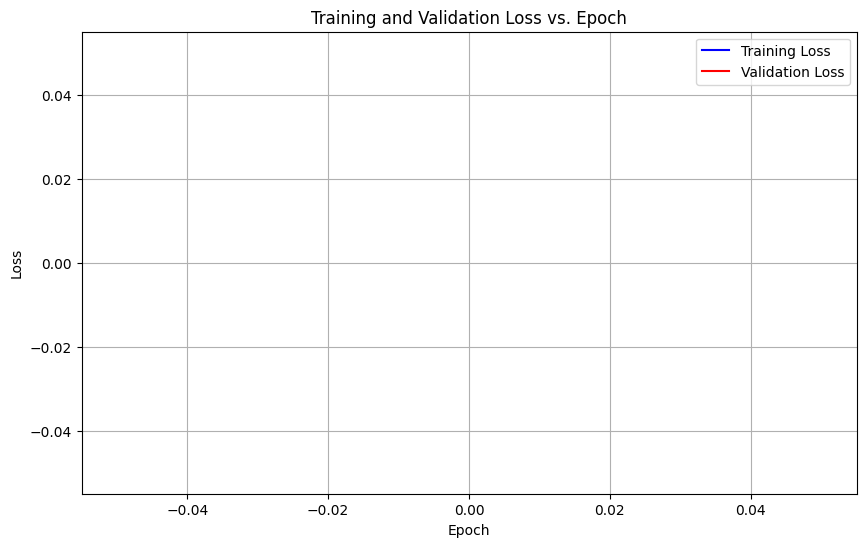

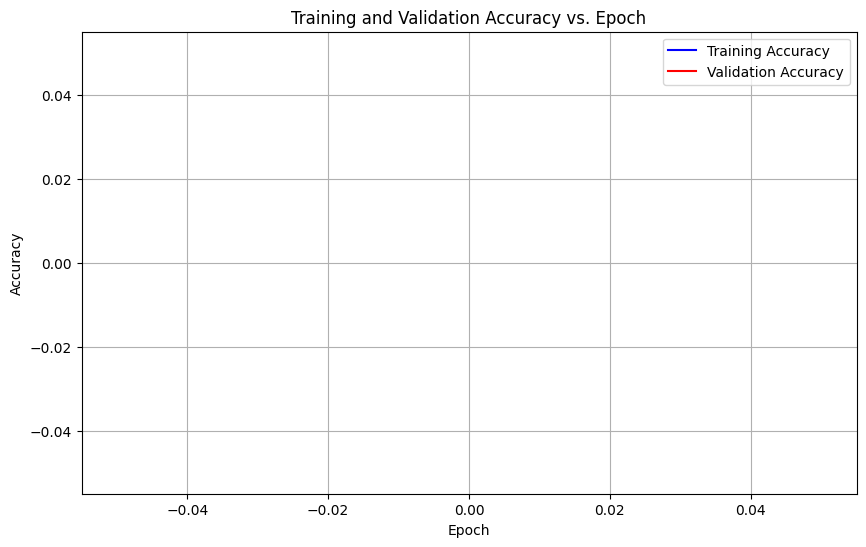

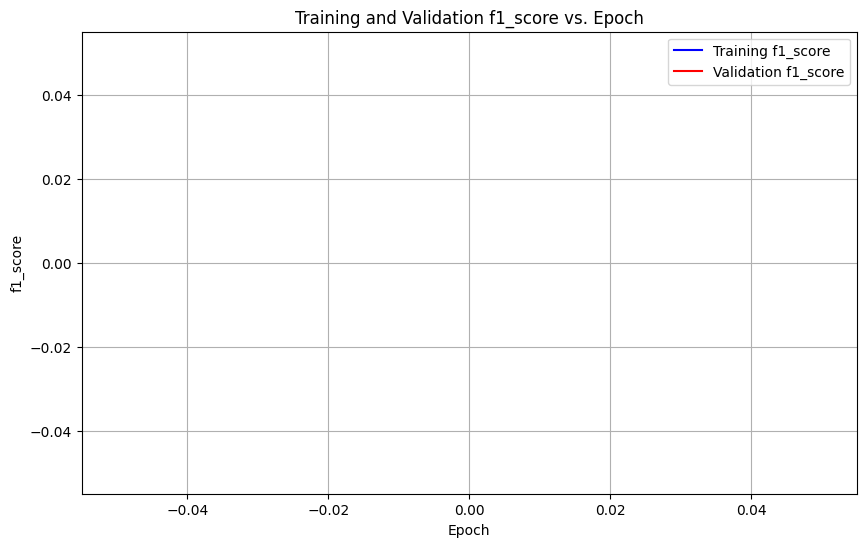

In [119]:
######################Generate graph for training,validation accuracy + loss ###################################


import matplotlib.pyplot as plt

validation_accuracy_array = np.array(validation_accuracy_array)
validation_loss_array = np.array(validation_loss_array)
training_accuracy_array = np.array(training_accuracy_array)
training_loss_array = np.array(training_loss_array)
epoch_array = np.array(epoch_array)


# Plot training and validation loss vs. epoch graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_array, training_loss_array, linestyle='-', color='b', label='Training Loss')
plt.plot(epoch_array, validation_loss_array, linestyle='-', color='r', label='Validation Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plot training and validation loss vs. epoch graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_array, training_accuracy_array, color='b', label='Training Accuracy')
plt.plot(epoch_array, validation_accuracy_array, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot validation f1_score and trainign f1 score vs. epoch graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_array, training_f1_array, color='b', label='Training f1_score')
plt.plot(epoch_array, validation_f1_array, color='r', label='Validation f1_score')
plt.title('Training and Validation f1_score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid(True)
plt.show()

In [120]:



test_feature,flattened_test_label = get_feature_label(test_dataset)

test_feature = np.array(test_feature).T 


flattened_test_label = np.array(flattened_test_label)

one_hot_test_label = perform_one_hot(flattened_test_label,total_class).T # dim = total_class x examples


test_forward_pass_val = NeuralNetwork.forward(test_feature)  # Take only 784 examples

print(flattened_test_label.shape)
# Calculate accuracy


test_predicted_labels = np.argmax(test_forward_pass_val, axis=0)
test_true_label = np.argmax(one_hot_test_label, axis=0)



test_accuracy = accuracy_score(test_true_label,test_predicted_labels)
test_recall = recall_score(test_true_label,test_predicted_labels,average='macro')
test_f1_score = f1_score(test_true_label,test_predicted_labels,average='macro')


test_loss = cross_entropy_loss(test_forward_pass_val, one_hot_test_label) / one_hot_test_label.shape[1]

print(f"Test loss: {test_loss} Test Accuracy: {test_accuracy * 100}% Test f1_score: {test_f1_score * 100}%")

C:\Users\rakib\AppData\Local\Temp\ipykernel_12084\813179952.py:269: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_np = np.array(img)


(10000,)
Test loss: 0.37274523584239566 Test Accuracy: 89.25% Test f1_score: 89.24620793002866%


In [121]:
#build confusion matrix

print(confusion_matrix(test_true_label, test_predicted_labels))

[[810   1  14  35   3   0 129   0   8   0]
 [  4 972   1  14   4   0   5   0   0   0]
 [ 27   1 814  13  87   0  56   1   1   0]
 [ 23   4  11 914  29   0  14   0   5   0]
 [  0   0  74  29 857   0  39   0   1   0]
 [  1   0   0   2   0 968   1  21   1   6]
 [100   1  70  23  81   0 718   0   6   1]
 [  0   0   0   0   0  17   0 967   0  16]
 [  2   0   5   5   5   3   8   4 968   0]
 [  0   0   0   0   0   7   1  55   0 937]]


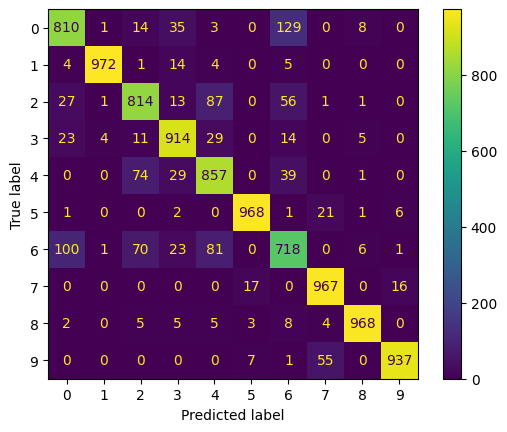

In [122]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(
   test_true_label, test_predicted_labels)

plt.show()

In [123]:
#re